<a href="https://colab.research.google.com/github/Lucian-N/Udacity-PyTorch/blob/master/final_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application


Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

#Imports



In [0]:
# Imports here

import os
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

import copy
import time
import json
import urllib.request
import zipfile
from collections import OrderedDict

import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler


In [2]:
# install and import torch


platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x5763a000 @  0x7fe6583bf2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
# GPU check


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# import and install correct Pillow
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one




Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


In [3]:

print(PIL.PILLOW_VERSION)

5.3.0


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# download flower data
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

In [0]:
# set data directories
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir +'/test'
dirs = {'train' : train_dir,
        'valid' : valid_dir}

In [0]:
batch_size = 32
# Transforms for the training and validation sets
data_transforms = {
    'train' : transforms.Compose([
      transforms.RandomRotation(10),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ColorJitter(brightness=0.2, hue=.1, saturation=.1),
      transforms.RandomVerticalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid' : transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'viz': transforms.Compose([
      transforms.RandomRotation(10),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ColorJitter(brightness=0.2, hue=.1, saturation=.1),
      transforms.RandomVerticalFlip(),
    ])
}

# Load the datasets with ImageFolder
image_datasets = {x: torchvision.datasets.ImageFolder(dirs[x], transform=data_transforms[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

# Use to see images after transform
viz_dataset = torchvision.datasets.ImageFolder(train_dir, transform=data_transforms['viz'])

# Define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size, shuffle=True) for x in ['train', 'valid']}

# Dataset size used for statistics
dataset_sizes = {x: len(image_datasets[x])
               for x in ['train', 'valid']}



In [0]:
#Matplot lib params
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

# ingore import errors
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

def show_dataset(dataset, n=10):
  _, ax = plt.subplots()
  imgs = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(7, 102, 10)))
  plt.imshow(imgs)
  ax.set_title('After Transformations Images Look Like This !!!!')
  plt.axis('off')

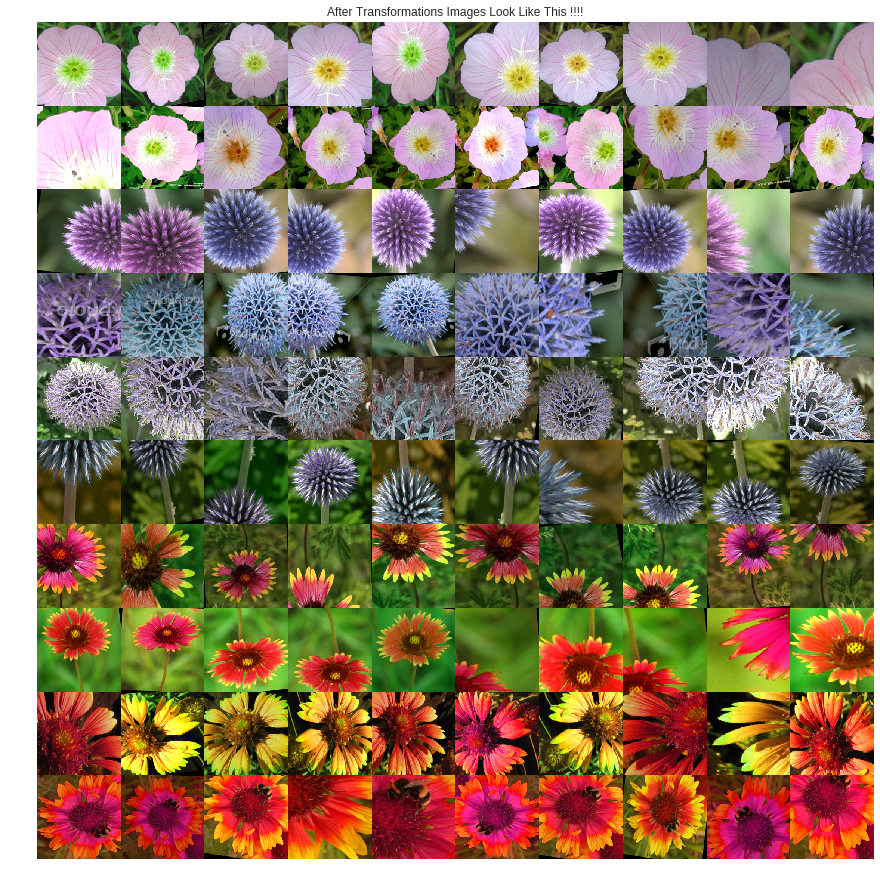

In [7]:
show_dataset(viz_dataset)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# Import trained neural net 
model = models.resnet152(pretrained=True)
#model = models.resnet18(pretrained=True)
#model = models.vgg19(pretrained=True)

In [10]:
# Freeze model parameters
for param in model.parameters():
  param.requires_grad_(True)

#for i , param in enumerate(model.parameters()):
 #   if(i>50):
  #    param.requires_grad=True
      

for i , param in enumerate(model.parameters()):
      print(i , param.requires_grad)

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 True
50 True
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 True
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 True
69 True
70 True
71 True
72 True
73 True
74 True
75 True
76 True
77 True
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True
117 True
118 True
119 True
120 True
121 True
122 True
123

In [11]:
num_ftrs = model.fc.in_features
# change the outputs from 512 to 102
model.fc = nn.Linear(num_ftrs, 102)

"""#Classifier
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 4096)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(4096, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))
model.fc = classifier """

"#Classifier\nclassifier = nn.Sequential(OrderedDict([\n    ('fc1', nn.Linear(num_ftrs, 4096)),\n    ('relu', nn.ReLU()),\n    ('fc2', nn.Linear(4096, 102)),\n    ('output', nn.LogSoftmax(dim=1))\n]))\nmodel.fc = classifier "

In [0]:
def train_model(model, criteria, optimizer, scheduler, num_epochs=25, device='cuda'):

    model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# Criteria NLLLoss which is recommended with Softmax final layer
#criteria = nn.NLLLoss()
#criteria = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
#optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 4 epochs
#sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
# Number of epochs
#eps = 15

#device = "cuda" if torch.cuda.is_available() else "cpu"
#model_ft = train_model(model, criteria, optimizer, sched, eps, device)

In [13]:

# 
criteria = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
eps = 21
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ft = train_model(model, criteria, optimizer, sched, eps, device)

Epoch 0/20
----------
train Loss: 3.5949 Acc: 0.2613
valid Loss: 2.2832 Acc: 0.5562

Epoch 1/20
----------
train Loss: 1.7646 Acc: 0.6538
valid Loss: 1.1546 Acc: 0.7702

Epoch 2/20
----------
train Loss: 0.9954 Acc: 0.8139
valid Loss: 0.7672 Acc: 0.8496

Epoch 3/20
----------
train Loss: 0.6784 Acc: 0.8698
valid Loss: 0.5445 Acc: 0.8936

Epoch 4/20
----------
train Loss: 0.5015 Acc: 0.8967
valid Loss: 0.4609 Acc: 0.8961

Epoch 5/20
----------
train Loss: 0.4232 Acc: 0.9139
valid Loss: 0.3385 Acc: 0.9303

Epoch 6/20
----------
train Loss: 0.3473 Acc: 0.9267
valid Loss: 0.3367 Acc: 0.9181

Epoch 7/20
----------
train Loss: 0.2953 Acc: 0.9383
valid Loss: 0.3003 Acc: 0.9328

Epoch 8/20
----------
train Loss: 0.2915 Acc: 0.9423
valid Loss: 0.2867 Acc: 0.9340

Epoch 9/20
----------
train Loss: 0.2846 Acc: 0.9420
valid Loss: 0.2852 Acc: 0.9315

Epoch 10/20
----------
train Loss: 0.2702 Acc: 0.9473
valid Loss: 0.2856 Acc: 0.9389

Epoch 11/20
----------
train Loss: 0.2797 Acc: 0.9422
valid Loss

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 

In [0]:

model_file_name = 'classifier_2.pth'
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'resnet152',
            'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx},
           model_file_name)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [39]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(checkpoint_path):
    """
    Load the model from a specified checkpoint file
    :param checkpoint_path:
    :return:
    """
    chpt = torch.load(checkpoint_path)
    pretrained_model = getattr(models, chpt['arch'])
    if callable(pretrained_model):
        model = pretrained_model(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture not recognized")

    model.class_to_idx = chpt['class_to_idx']
    
    num_ftrs = model.fc.in_features
    print(num_ftrs)
    # change the outputs from 512 to 102
    model.fc = nn.Linear(num_ftrs, 102)
  


    model.load_state_dict(chpt['state_dict'])

    return model


model = load_model('classifier_2_trained.pth')


2048


In [0]:
 #  Create the classifier
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(2048, 1024)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(1024, 512)),
        ('relu',nn.ReLU()),
        ('hidden', nn.Linear(512, 102)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    # Put the classifier on the pretrained network
    model.classifier = classifier

In [0]:
print(model)

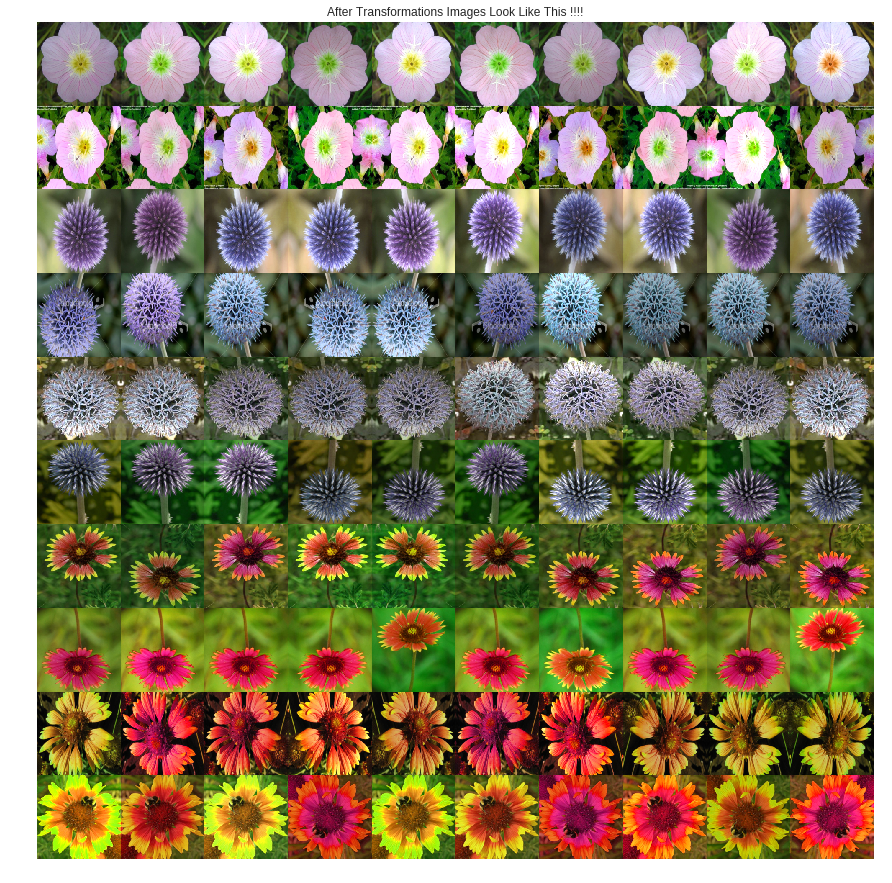

In [36]:
batch_size = 128
# Transforms for the training and validation sets
data_transforms = {
    'train' : transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomHorizontalFlip(.5),
      transforms.RandomVerticalFlip(.5),
      transforms.CenterCrop(200),
      transforms.ColorJitter(brightness=0.2, hue=.1, saturation=.1),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid' : transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomHorizontalFlip(.5),
      transforms.RandomVerticalFlip(.75),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'viz': transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomHorizontalFlip(.5),
      transforms.RandomVerticalFlip(.5),
      transforms.CenterCrop(200),
      transforms.ColorJitter(brightness=0.2, hue=.1, saturation=.1),
    ])
}

# Load the datasets with ImageFolder
image_datasets2 = {x: torchvision.datasets.ImageFolder(dirs[x], transform=data_transforms[x]) for x in ['train', 'valid']}
class_names2 = image_datasets2['train'].classes

# Use to see images after transform
viz_dataset2 = torchvision.datasets.ImageFolder(train_dir, transform=data_transforms['viz'])

# Define the dataloaders
dataloaders2 = {x: torch.utils.data.DataLoader(image_datasets2[x], batch_size, shuffle=True) for x in ['train', 'valid']}

# Dataset size used for statistics
dataset_sizes2 = {x: len(image_datasets2[x])
               for x in ['train', 'valid']}

show_dataset(viz_dataset2)


In [0]:
# Training model for frozen network
def train_model2(model, criteria, optimizer, scheduler, num_epochs=25, device='cuda'):

    model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders2[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes2[phase]
            epoch_acc = running_corrects.double() / dataset_sizes2[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [37]:

# 
criteria = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.95)
eps = 7
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ft = train_model2(model, criteria, optimizer, sched, eps, device)

Epoch 0/6
----------
train Loss: 0.1575 Acc: 0.9724
valid Loss: 0.1977 Acc: 0.9535

Epoch 1/6
----------
train Loss: 0.1478 Acc: 0.9733
valid Loss: 0.1829 Acc: 0.9584

Epoch 2/6
----------
train Loss: 0.1431 Acc: 0.9766
valid Loss: 0.1942 Acc: 0.9523

Epoch 3/6
----------
train Loss: 0.1401 Acc: 0.9788
valid Loss: 0.1889 Acc: 0.9560

Epoch 4/6
----------
train Loss: 0.1372 Acc: 0.9771
valid Loss: 0.1823 Acc: 0.9572

Epoch 5/6
----------
train Loss: 0.1355 Acc: 0.9773
valid Loss: 0.1782 Acc: 0.9548

Epoch 6/6
----------
train Loss: 0.1318 Acc: 0.9770
valid Loss: 0.1799 Acc: 0.9560

Training complete in 31m 7s
Best val Acc: 0.958435


In [0]:

model_file_name = 'classifier_2_trained.pth'
model.class_to_idx = image_datasets2['train'].class_to_idx
model.cpu()
torch.save({'arch': 'resnet152',
            'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx},
           model_file_name)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image_path):
    """
    Scales, crops, and normalizes a PIL image for a PyTorch
    model, returns an Numpy array
    """
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop
    left_margin = (img.width - 224) / 2
    bottom_margin = (img.height - 224) / 2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,
                    top_margin))
    # Normalize
    img = np.array(img) / 255
    mean = np.array([0.485, 0.456, 0.406])  # provided mean
    std = np.array([0.229, 0.224, 0.225])  # provided std
    img = (img - mean) / std

    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))

    return img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, top_num=5):
    """
    Predict the class of an image, given a model
    :param image_path:
    :param model:
    :param top_num:
    :return:
    """
    # Process image
    img = process_image(image_path)

    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)

    image_tensor.to('cpu')
    model_input.to('cpu')
    model.to('cpu')

    # Probs
    probs = torch.exp(model.forward(model_input))

    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0]
    top_labs = top_labs.detach().numpy().tolist()[0]

    # Convert indices to classes
    idx_to_class = {val: key for key, val in
                    model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

KeyError: ignored

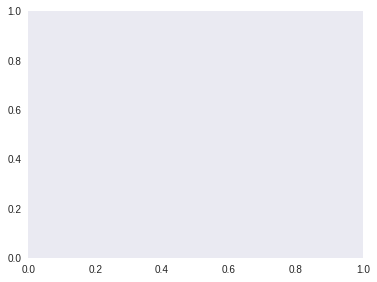

In [0]:
# TODO: Display an image along with the top 5 classes
def plot_solution(image_path, model):
    """
    Plot an image with the top 5 class prediction
    :param image_path:
    :param model:
    :return:
    """
    # Set up plot
    plt.figure(figsize=(6, 10))
    ax = plt.subplot(2, 1, 1)
    # Set up title
    flower_num = image_path.split('/')[3]
    title_ = cat_to_name[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title=title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model)
    # Plot bar chart
    plt.subplot(2, 1, 2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()


image_path = os.path.join(valid_dir, '28/image_05265.jpg')
plot_solution(image_path, model)